# Bulldozer Sale Price Prediction
## 1. Problem defition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. Check data/bluebook-for-bulldozers/Data Dictionary.xlsx

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy, pandas as pd, seaborn
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Import Train+Validation dataset
data = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", parse_dates=["saledate"], low_memory=False)
data.sort_values(by=["saledate"], inplace=True)
data.info()
#data.head(20)

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')


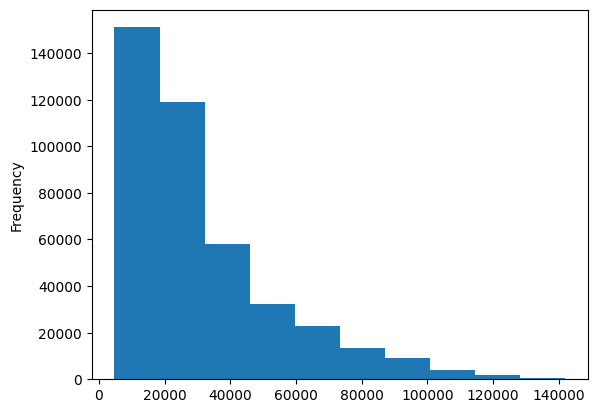

In [101]:
print(data.columns)
data.SalePrice.plot.hist();

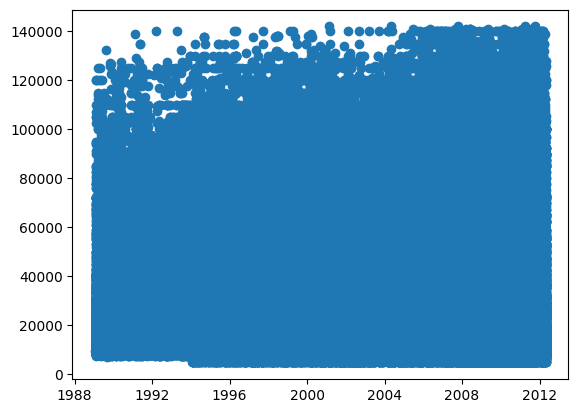

In [102]:
fig, ax = plt.subplots()
ax.scatter(data.saledate, data.SalePrice);

In [103]:
# saledate is a pandas Series of datetime propery
print(f"saledate dtype: {data.saledate.dtype}")
print("\nsaledate info:")
data.saledate.info()
print(f"\nsaledate describe:")
print(data.saledate.describe())
data.state.value_counts()

saledate dtype: datetime64[ns]

saledate info:
<class 'pandas.core.series.Series'>
Index: 412698 entries, 205615 to 409203
Series name: saledate
Non-Null Count   Dtype         
--------------   -----         
412698 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 6.3 MB

saledate describe:
count                           412698
mean     2004-10-19 01:54:17.182733952
min                1989-01-17 00:00:00
25%                2000-12-06 00:00:00
50%                2006-06-28 00:00:00
75%                2009-05-28 00:00:00
max                2012-04-28 00:00:00
Name: saledate, dtype: object


state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virgi

In [2]:
def ProcessTimeStamp(data: pd.DataFrame) -> None:
    data["saleYear"] = data.saledate.dt.year
    data["saleMonth"] = data.saledate.dt.month
    data["saleDay"] = data.saledate.dt.day
    data["saleDayOfWeek"] = data.saledate.dt.dayofweek
    data["saleDayOfYear"] = data.saledate.dt.dayofyear

    # model.fit() hits "TypeError: Cannot cast DatetimeArray to dtype float32" due to this datetime dtype of 'saledata'
    # Now we've enriched our DataFrame with date time features, we can remove 'saledate'
    data.drop("saledate", axis=1, inplace=True)

In [3]:
def ProcessData(data: pd.DataFrame) -> dict:
    """
    (1) Remove Timestamp dtype. model.fit() hits "TypeError: Cannot cast DatetimeArray to dtype float32" due to this datetime dtype of 'saledata'
    (2) Extract information from Timestamp dtype into individual columns
    (3) Convert object dtype into Category
    (4) Fill NULL / N.A missing data
    Input:
    data - Train, Cross-validation OR Test datasets. Don't mix and match or combine them as this will affect the performance of the model.
    """
    # 1. Create a dictionary to store column to category values (e.g. we turn our category types into numbers but we keep a record so we can go back)
    column_to_category_dict = {}
    ProcessTimeStamp(data)
    # Convert object dtype to category dtype
    for k,v in data.items():
        # v is Series
        if pd.api.types.is_object_dtype(v):
            # 5. Ensure content is categorical and get its category codes
            categories = pd.Categorical(v)
            if pd.isna(v).sum() or pd.isnull(v).sum():
                # NULL / N.A will be assigned -1 by default. +1 here will offset all codes by +1. So, Null / N.A will have 0
                category_codes = categories.codes + 1  # prevents -1 (the default for NaN values) from being used for missing values (we'll treat missing values as 0)
            else:
                category_codes = categories.codes
            # 6. Add column key to dictionary with code: category mapping per column
            column_to_category_dict[k] = dict(zip(category_codes, categories))
            
            # 7. Set the column to the numerical values (the category code value) 
            data[k] = category_codes
        elif pd.api.types.is_numeric_dtype(v):
            if pd.isna(v).sum() or pd.isnull(v).sum():
                # Fix missing numerical values        
                # Add a flag to mark originally missing value
                data[f"{k}_missing"] = pd.isnull(v).astype(int)
                # Fill missing values with media (NOT mean as mean is more supceptible to outliers)
                data[k] = v.fillna(v.median()) # XXX: Mixing Train with Cross-Validation and/or Test dataset will affect this value.
                # Fix missing categorical values
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    return column_to_category_dict

In [4]:
# Extract January 1, 2012 - April 30, 2012 to a validation dataset
data_train = data[data.saledate.dt.year != 2012]
data_validation = data[data.saledate.dt.year == 2012]
train_map = ProcessData(data_train)
validation_map = ProcessData(data_validation)
#print("Train dataset with object dtype encoded using categorical codes:")
#data_train.sample(10)
# Check the UsageBand (measure of bulldozer usage)
print("UsageBand encoed using categorical codes:")
for key, value in sorted(train_map["UsageBand"].items()): # note: calling sorted() on dictionary.items() sorts the dictionary by keys 
    print(f"{key} -> {value}")
# Check the first 10 state column values
print("state encoed using categorical codes:")
for key, value in sorted(train_map["state"].items())[:10]:
    print(f"{key} -> {value}")
assert not data_train.isna().values.any()
assert not data_validation.isna().values.any()

/tmp/ipykernel_719077/3582473469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["saleYear"] = data.saledate.dt.year
/tmp/ipykernel_719077/3582473469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["saleMonth"] = data.saledate.dt.month
/tmp/ipykernel_719077/3582473469.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

UsageBand encoed using categorical codes:
0 -> nan
1 -> High
2 -> Low
3 -> Medium
state encoed using categorical codes:
0 -> Alabama
1 -> Alaska
2 -> Arizona
3 -> Arkansas
4 -> California
5 -> Colorado
6 -> Connecticut
7 -> Delaware
8 -> Florida
9 -> Georgia


/tmp/ipykernel_719077/3582473469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["saleYear"] = data.saledate.dt.year
/tmp/ipykernel_719077/3582473469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["saleMonth"] = data.saledate.dt.month
/tmp/ipykernel_719077/3582473469.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

We define our different feature types so we can use different preprocessing methods on each type.

Scikit-Learn has many built-in methods for preprocessing data under the [`sklearn.preprocessing` module](https://scikit-learn.org/stable/api/sklearn.preprocessing.html#).

Reference: [preprocessing data section of the Scikit-Learn user guide](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) for more details.

For now, let's focus on turning our categorical features into numbers (from object/string datatype to numeric datatype).

The practice of turning non-numerical features into numerical features is often referred to as [**encoding**](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features).

There are several encoders available for different use cases.

| Encoder | Description | Use case | For use on |
| ----- | ----- | ----- | ----- |
| [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder) | Encode target labels with values between 0 and n_classes-1. | Useful for turning classification target values into numeric representations. | Target labels. |
| [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#onehotencoder) | Encode categorical features as a [one-hot numeric array](https://en.wikipedia.org/wiki/One-hot). | Turns every positive class of a unique category into a 1 and every negative class into a 0. | Categorical variables/features. |
| [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#ordinalencoder) | Encode categorical features as an integer array. | Turn unique categorical values into a range of integers, for example, 0 maps to 'cat', 1 maps to 'dog', etc. | Categorical variables/features. |
| [`TargetEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#targetencoder) | Encode regression and classification targets into a shrunk estimate of the average target values for observations of the category. | Useful for converting targets into a certain range of values. | Target variables. |

For our case, we're going to start with `OrdinalEncoder`.

When transforming/encoding values with Scikit-Learn, the steps as follows:

1. Instantiate an encoder, for example, `sklearn.preprocessing.OrdinalEncoder`.
2. Use the [`sklearn.preprocessing.OrdinalEncoder.fit`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder.fit) method on the **training** data (this helps the encoder learn a mapping of categorical to numeric values).
3. Use the [`sklearn.preprocessing.OrdinalEncoder.transform`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder.transform) method on the **training** data to apply the learned mapping from categorical to numeric values.
    * **Note:** The [`sklearn.preprocessing.OrdinalEncoder.fit_transform`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder.fit_transform) method combines steps 1 & 2 into a single method.
4. Apply the learned mapping to subsequent datasets such as **validation** and **test** splits using `sklearn.preprocessing.OrdinalEncoder.transform` only.

Notice how the `fit` and `fit_transform` methods were reserved for the **training dataset only**.

This is because in practice the validation and testing datasets are meant to be unseen, meaning only information from the training dataset should be used to preprocess the validation/test datasets.

In short:

1. Instantiate an encoder such as `sklearn.preprocessing.OrdinalEncoder`.
2. Fit the encoder to and transform the training dataset categorical variables/features with `sklearn.preprocessing.OrdinalEncoder.fit_transform`.
3. Transform categorical variables/features from subsequent datasets such as the validation and test datasets with the learned encoding from step 2 using `sklearn.preprocessing.OridinalEncoder.transform`. 
    * **Note:** Notice the use of the `transform` method on validation/test datasets rather than `fit_transform`.

Let's do it!

We'll use the `OrdinalEncoder` class to fill any missing values with `np.nan` (`NaN`).

We'll also make sure to only use the `OrdinalEncoder` on the categorical features of our DataFrame.

Finally, the `OrdinalEncoder` expects all input variables to be of the same type (e.g. either numeric only or string only) so we'll make sure all the input variables are strings only using [`pandas.DataFrame.astype(str)`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html).

In [9]:
# Extract January 1, 2012 - April 30, 2012 to a validation dataset
data_train = data[data.saledate.dt.year != 2012]
data_validation = data[data.saledate.dt.year == 2012]

ProcessTimeStamp(data_train)
ProcessTimeStamp(data_validation)

# Make sure both datasets have exactly the same columns!
data_train.shape, data_validation.shape

print(f"{len(data_train)} data_train")
X_train = data_train.drop("SalePrice", axis=1)
Y_train = data_train.SalePrice

print(f"{len(data_validation)} data_validation")
X_validation = data_validation.drop("SalePrice", axis=1)
Y_validation = data_validation.SalePrice

X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape
#X_train.info()

# Define numerical and categorical features
numerical_features = [label for label, content in X_train.items() if pd.api.types.is_numeric_dtype(content)]
categorical_features = [label for label, content in X_train.items() if not pd.api.types.is_numeric_dtype(content)]

print(f"[INFO] Numeric features: {numerical_features}")
print(f"[INFO] Categorical features: {categorical_features[:10]}...")

# 1. Create an ordinal encoder (turns category items into numeric representation)
ordinal_encoder = OrdinalEncoder(categories="auto",
                                 handle_unknown="use_encoded_value",
                                 unknown_value=numpy.nan,
                                 encoded_missing_value=numpy.nan) # treat unknown categories as np.nan (or None)

# 2. Fit and transform the categorical columns of X_train
#X_train_preprocessed = X_train.copy() # make copies of the oringal DataFrames so we can keep the original values in tact and view them later
X_train[categorical_features] = ordinal_encoder.fit_transform(X_train[categorical_features].astype(str)) # OrdinalEncoder expects all values as the same type (e.g. string or numeric only)

# 3. Transform the categorical columns of X_valid and X_test
#X_valid_preprocessed = X_valid.copy()
X_validation[categorical_features] = ordinal_encoder.transform(X_validation[categorical_features].astype(str)) # only use `transform` on the validation data
#X_train.head()

/tmp/ipykernel_719077/3582473469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["saleYear"] = data.saledate.dt.year
/tmp/ipykernel_719077/3582473469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["saleMonth"] = data.saledate.dt.month
/tmp/ipykernel_719077/3582473469.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

401125 data_train
11573 data_validation
[INFO] Numeric features: ['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'saleYear', 'saleMonth', 'saleDay', 'saleDayOfWeek', 'saleDayOfYear']
[INFO] Categorical features: ['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup']...


In [28]:
# Validate missing values are fixed by the OrdinalEncoder
assert not X_train[categorical_features].isnull().values.any()
assert not X_train[categorical_features].isna().values.any()
assert not X_train.isnull().values.any()
assert not X_train.isna().values.any()

X_train[categorical_features].isna().sum().sort_values(ascending=False)[:10]

# Retrieve the original categorical values
# We can do using the [`OrdinalEncoder.categories_` attribute](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder.fit_transform).
# This will return the categories of each feature found during `fit` (or during `fit_transform`), the categories will be in the order of the features seen (same order as the columns of the DataFrame).
# Let's inspect the first three categories
ordinal_encoder.categories_[:3]

# Since these come in the order of the features seen, we can create a mapping of these using the categorical column names of our DataFrame.
# Create a dictionary of dictionaries mapping column names and their variables to their numerical encoding
column_to_category_mapping = {}

for column_name, category_values in zip(categorical_features, ordinal_encoder.categories_):
    int_to_category = {i: category for i, category in enumerate(category_values)}
    column_to_category_mapping[column_name] = int_to_category

# Inspect an example column name to category mapping
print(f"State category mapping: {column_to_category_mapping["state"]}")
print(f"UsageBand category mapping: {column_to_category_mapping["UsageBand"]}")

AssertionError: 

In [14]:
#X_train[X_train.isnull().any(axis=1)]
X_train.isna().sum().sort_values(ascending=False)
#X_train.auctioneerID.info()
#X_train.MachineHoursCurrentMeter.info()
#assert not X_train[categorical_features].isnull().values.any() # This will fail as validation dataset DOES contain NA values
#assert not X_train[categorical_features].isna().values.any() # This will fail as validation dataset DOES contain NA values
#X_train[categorical_features].isna().sum().sort_values(ascending=False)

MachineHoursCurrentMeter    258360
auctioneerID                 20136
SalesID                          0
MachineID                        0
datasource                       0
ModelID                          0
YearMade                         0
UsageBand                        0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc                  0
fiModelSeries                    0
fiModelDescriptor                0
ProductSize                      0
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                     0
Enclosure                        0
Forks                            0
Pad_Type                         0
Ride_Control                     0
Stick                            0
Transmission                     0
Turbocharged                     0
Blade_Extension                  0
Blade_Width                      0
Enclosure_Type      

In [15]:
X_validation[X_validation[categorical_features].isnull().any(axis=1)][categorical_features]
#assert not X_validation[categorical_features].isnull().values.any() This will fail as validation dataset DOES contain NA values
#assert not X_validation[categorical_features].isna().values.any() This will fail as validation dataset DOES contain NA values
X_validation[categorical_features].isna().sum().sort_values(ascending=False)[:10]

fiModelDesc           88
fiBaseModel           19
fiSecondaryDesc        2
fiModelSeries          1
fiModelDescriptor      1
UsageBand              0
ProductSize            0
fiProductClassDesc     0
state                  0
ProductGroup           0
dtype: int64

In [16]:
X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape

((401125, 56), (401125,), (11573, 56), (11573,))

In [17]:
X_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11573 entries, 405675 to 409203
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   11573 non-null  int64  
 1   MachineID                 11573 non-null  int64  
 2   ModelID                   11573 non-null  int64  
 3   datasource                11573 non-null  int64  
 4   auctioneerID              11573 non-null  float64
 5   YearMade                  11573 non-null  int64  
 6   MachineHoursCurrentMeter  4739 non-null   float64
 7   UsageBand                 11573 non-null  float64
 8   fiModelDesc               11485 non-null  float64
 9   fiBaseModel               11554 non-null  float64
 10  fiSecondaryDesc           11571 non-null  float64
 11  fiModelSeries             11572 non-null  float64
 12  fiModelDescriptor         11572 non-null  float64
 13  ProductSize               11573 non-null  float64
 14  fiPro

In [10]:
# Save preprocessed data so far into csv
X_train.to_csv("data/bluebook-for-bulldozers/Train_processed.csv", index=False)

In [18]:
# The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score
def rmsle(truth, prediction):
    return numpy.sqrt(mean_squared_log_error(truth, prediction))

def Evaluate(model, train_features, train_labels, validation_features, validation_labels):
    train_predictions = model.predict(train_features)
    #print(f"\nTraining predictions: {train_predictions}")
    validation_predictions = model.predict(validation_features)
    #print(f"\nValidation predictions: {validation_predictions}")
    scores = {
        "Train R^2": r2_score(train_labels, train_predictions), # Prefect score is 1.0
        "Validation R^2": r2_score(validation_labels, validation_predictions),
        "Train MAE": mean_absolute_error(train_labels, train_predictions), # Perfect score is 0.0
        "Validation MAE": mean_absolute_error(validation_labels, validation_predictions),
        "Train RMSLE": None if (train_predictions <= -1).any() else rmsle(train_labels, train_predictions), # metrics requirement of the competition. # Perfect score is 0.0
        "Validation RMSLE": None if (validation_predictions <= -1).any() else rmsle(validation_labels, validation_predictions) # metrics requirement of the competition
    }
    return scores

In [19]:
# 412698 rows in the dataset. Set max_samples to reduce training time and speed up experiment cycles. n_jobs defaults to None which means 1.
model = LinearRegression(n_jobs=-1)
# LinearRegression does not accept missing values encoded as NaN natively. 
# For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer 
model.fit(X_train, Y_train) # This fails since there are NaN values in X_train
scores = Evaluate(model, X_train, Y_train, X_validation, Y_validation)
print("Linear Regression scores:")
scores

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [20]:
model = RandomForestRegressor(n_jobs=-1) # 412698 rows in the dataset. Set max_samples to reduce training time and speed up experiment cycles. n_jobs defaults to None which means 1.
model.fit(X_train, Y_train)
scores = Evaluate(model, X_train, Y_train, X_validation, Y_validation)
print("RandomForestRegressor scores:")
scores

RandomForestRegressor scores:


{'Train R^2': 0.987263162705383,
 'Validation R^2': 0.8712308002980526,
 'Train MAE': 1596.277873971123,
 'Validation MAE': 6154.358480947032,
 'Train RMSLE': np.float64(0.08549109187396745),
 'Validation RMSLE': np.float64(0.25594828685043597)}

In [146]:
# Hyperparameter tuning using RandomizedSearchCV
params = {"n_estimators": numpy.arange(10, 1000, 20),
            "max_depth": [None, 7, 11, 13, 17, 19],
            "min_samples_split": numpy.arange(1, 20, 2),
            "min_samples_leaf": numpy.arange(1, 20, 2),
            "max_features": [0.5, 1, "sqrt", "auto"],
            "max_samples": [100000, 200000, 250000]
        }
print(f"Baseline model scores: {scores}")
print("=== RandomForestRegressor ===")
random_forest_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1), param_distributions=params, cv=5, n_iter=25,verbose=True)
random_forest_model.fit(X_train, Y_train)
print(f"Best params : {random_forest_model.best_params_}")
print(f"Score: {random_forest_model.score(X_validation, Y_validation)}")

Baseline model scores: {'Train R^2': 0.9875295913834697, 'Validation R^2': 0.4927078851582598, 'Train MAE': 1578.8372838142725, 'Validation MAE': 11080.54301218353, 'Train RMSLE': np.float64(0.08423354524661288), 'Validation RMSLE': np.float64(0.49042906970088257)}
=== RandomForestRegressor ===
Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: 

In [21]:
# Use the test dataset
test_data = pd.read_csv("data/bluebook-for-bulldozers/Test.csv", parse_dates=["saledate"])
test_data.sort_values(by=["saledate"], inplace=True)
#ProcessData(test_data)
ProcessTimeStamp(test_data)
missing = set(X_train.columns) - set(test_data.columns)
missing1 = set(test_data.columns) - set(X_train.columns)
print(f"\nColumns missing from test data: {missing} {missing1}")
for i in missing:
    if "_missing" in i:
        test_data[i] = False
    else:
        raise ValueError(f"Unexpected missing column {i} from test dataset!")
missing = set(X_train.columns) - set(test_data.columns)
assert 0 == len(missing)
#test_data.sort_index(axis=1, inplace=True)
test_data[categorical_features] = ordinal_encoder.transform(test_data[categorical_features].astype(str)) # only use `transform` on the validation data
test_data.info()


Columns missing from test data: set() set()
<class 'pandas.core.frame.DataFrame'>
Index: 12457 entries, 1408 to 9803
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   12457 non-null  int64  
 1   MachineID                 12457 non-null  int64  
 2   ModelID                   12457 non-null  int64  
 3   datasource                12457 non-null  int64  
 4   auctioneerID              12457 non-null  int64  
 5   YearMade                  12457 non-null  int64  
 6   MachineHoursCurrentMeter  2129 non-null   float64
 7   UsageBand                 12457 non-null  float64
 8   fiModelDesc               12349 non-null  float64
 9   fiBaseModel               12431 non-null  float64
 10  fiSecondaryDesc           12449 non-null  float64
 11  fiModelSeries             12456 non-null  float64
 12  fiModelDescriptor         12452 non-null  float64
 13  ProductSize        

In [22]:
predictions = model.predict(test_data)
print("Test predictions:")
predictions

Test predictions:


array([ 7694., 18350., 25380., ..., 40780., 43341., 47336.],
      shape=(12457,))

## Feature Importance
### Which feature(s) contribute most to the outcomes of the model and how?

In [29]:
def CorrelationMatrixHeatMap(df : pd.DataFrame):
    matrix = df.corr()
    plt.subplots(figsize=(15,10))
    ax = seaborn.heatmap(matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu") # https://r02b.github.io/seaborn_palettes/
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5) # To avoid the truncation in y-axis
    
def FeatureImportance(columns, metrics, n=25):
    df = pd.DataFrame({
        "Features": columns,
        "Metrics": metrics
    }).sort_values("Metrics", ascending=False, ignore_index=True).reset_index(drop=True)
    fig, ax = plt.subplots()
    ax.barh(df.Features[:n], df.Metrics[:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Metrics")
    ax.set_title("Feature Importance")
    ax.invert_yaxis()

In [30]:
# Linear Regression
model = LinearRegression(n_jobs=-1)
model.fit(X_train, Y_train)
model.coef_
features = dict(zip(data.columns, list(model.coef_)))
print(f"features coefficients: {features}")
CorrelationMatrixHeatMap(data_train.corr())
features_df = pd.DataFrame(features, index=[0])
features_df.T.plot.bar(title="Linear Regression Feature Coefficients", legend=False, figsize=(20,10))
FeatureImportance(X_train.columns, model.coef_)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, Y_train)
model.feature_importances_
features = dict(zip(data.columns, list(model.feature_importances_)))
print(f"features coefficients: {features}")
CorrelationMatrixHeatMap(data_train.corr())
features_df = pd.DataFrame(features, index=[0])
features_df.T.plot.bar(title="RandomForestRegressor Feature Coefficients", legend=False, figsize=(20,10))
FeatureImportance(X_train.columns, model.feature_importances_)